<a href="https://colab.research.google.com/github/vasanthi2004/Ai-based-smart-detection-of-lateral-flow-test-kits/blob/main/Copy_of_covid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


In [ ]:
import os

dataset_path = "/content/drive/MyDrive/Major_Project"  # Make sure this matches your actual path

if os.path.exists(dataset_path):
    print("✅ Dataset directory found!")
    print("📂 Contents:", os.listdir(dataset_path))  # List contents
else:
    print("❌ Error: Dataset directory not found! Check folder name in Google Drive.")


✅ Dataset directory found!
📂 Contents: ['Negative', 'Positive', 'models']


In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Define correct dataset paths
positive_dir = "/content/drive/MyDrive/Major_Project/Positive"  # Capital 'P'
negative_dir = "/content/drive/MyDrive/Major_Project/Negative"  # Capital 'N'

# Check if directories exist
if not os.path.exists(positive_dir):
    print(f"Error: Positive directory not found at {positive_dir}")

if not os.path.exists(negative_dir):
    print(f"Error: Negative directory not found at {negative_dir}")

# List some images from each category
if os.path.exists(positive_dir) and os.path.exists(negative_dir):
    positive_images = os.listdir(positive_dir)[:5]
    negative_images = os.listdir(negative_dir)[:5]

    print(f"✅ Positive Samples: {positive_images}")



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Positive Samples: ['1650442222468.jpg', '1650442222162.jpg', '1650442222490.jpg', '1650442222622.jpg', '1650442222652.jpg']


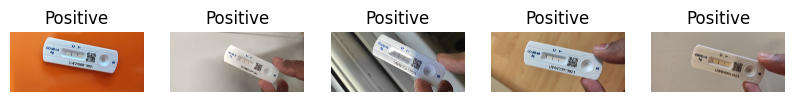

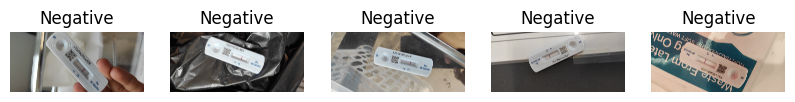

In [ ]:
def display_images(image_paths, title, img_dir):
    plt.figure(figsize=(10, 5))
    for i, img_name in enumerate(image_paths):
        img_path = os.path.join(img_dir, img_name)
        if not os.path.exists(img_path):
            print(f"⚠️ Warning: {img_path} not found, skipping.")
            continue
        try:
            img = Image.open(img_path)
            plt.subplot(2, 5, i + 1)
            plt.imshow(img)
            plt.axis("off")
            plt.title(title)
        except Exception as e:
            print(f"⚠️ Could not open {img_name}: {e}")
    plt.show()

# Display sample images
display_images(positive_images, "Positive", positive_dir)
display_images(negative_images, "Negative", negative_dir)


In [ ]:
import cv2
import numpy as np

def preprocess_image(img_path, target_size=(224, 224)):
    try:
        # Load image
        img = cv2.imread(img_path)
        if img is None:
            raise FileNotFoundError(f"❌ Error: Image not found at {img_path}")

        # Convert BGR to RGB
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Get original dimensions
        h, w = img.shape[:2]

        # Crop center square (preserving aspect ratio)
        min_dim = min(h, w)
        start_x, start_y = (w - min_dim) // 2, (h - min_dim) // 2
        img_cropped = img[start_y:start_y + min_dim, start_x:start_x + min_dim]

        # Resize to target size
        img_resized = cv2.resize(img_cropped, target_size, interpolation=cv2.INTER_AREA)

        # Normalize (scale pixel values between 0 and 1)
        img_normalized = img_resized.astype(np.float32) / 255.0

        return img_normalized
    except Exception as e:
        print(f"⚠️ Error processing image {img_path}: {e}")
        return None  # Return None for failed images


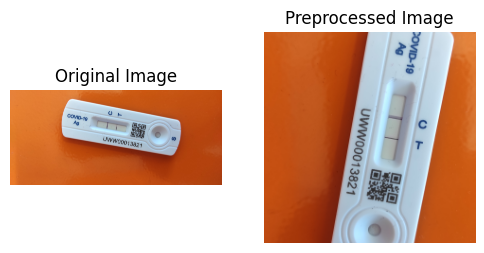

In [ ]:
import os
import matplotlib.pyplot as plt
from PIL import Image

# Test preprocessing on a sample image
if positive_images:
    sample_img_path = os.path.join(positive_dir, positive_images[0])

    if os.path.exists(sample_img_path):
        processed_img = preprocess_image(sample_img_path)

        if processed_img is not None:
            # Display original and preprocessed image
            plt.figure(figsize=(6, 3))

            # Original Image
            plt.subplot(1, 2, 1)
            plt.imshow(Image.open(sample_img_path))
            plt.title("Original Image")
            plt.axis("off")

            # Preprocessed Image
            plt.subplot(1, 2, 2)
            plt.imshow(processed_img)  # Display correctly
            plt.title("Preprocessed Image")
            plt.axis("off")

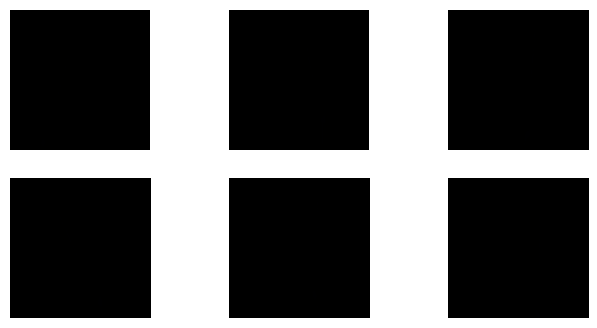

In [ ]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Ensure processed_img is defined
if 'processed_img' in locals() and processed_img is not None:
    # Expand dimensions to create a batch of 1 image
    sample_img = np.expand_dims(processed_img, axis=0)  # Shape: (1, 224, 224, 3)

    # Define augmentation transformations
    datagen = ImageDataGenerator(
        rotation_range=20,       # Rotate images by 20 degrees
        width_shift_range=0.2,   # Shift width by 20%
        height_shift_range=0.2,  # Shift height by 20%
        zoom_range=0.2,          # Zoom in/out by 20%
        horizontal_flip=True,    # Flip images horizontally
        rescale=1./255           # Normalize pixel values (0-1)
    )

    # Create an iterator for augmentation
    aug_iter = datagen.flow(sample_img, batch_size=1)

    # Generate and plot augmented images
    plt.figure(figsize=(8, 4))
    for i in range(6):
        batch = next(aug_iter)  # Get the next augmented image
        plt.subplot(2, 3, i+1)
        plt.imshow(batch[0])  # Display image correctly
        plt.axis("off")

    plt.show()
else:
    print("⚠️ Error: `processed_img` is not defined or not properly loaded.")


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create training and validation data generators
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rescale=1./255,
    validation_split=0.2  # 80% train, 20% validation split
)

train_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode="binary",
    subset="training"
)

val_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode="binary",
    subset="validation"
)

print("✅ Classes Loaded:", train_generator.class_indices)


Found 103 images belonging to 3 classes.
Found 25 images belonging to 3 classes.
✅ Classes Loaded: {'Negative': 0, 'Positive': 1, 'models': 2}


In [ ]:
import tensorflow as tf

# Define your model architecture
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Now you can train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,  # Adjust based on dataset size
    verbose=1
)



/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 44s 10s/step - accuracy: 0.7848 - loss: 1.5373 - val_accuracy: 0.6400 - val_loss: 0.6844
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 71s 6s/step - accuracy: 0.8220 - loss: 0.6174 - val_accuracy: 0.8000 - val_loss: 0.5225
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 40s 9s/step - accuracy: 0.8366 - loss: 0.4777 - val_accuracy: 0.8000 - val_loss: 0.5466
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 30s 7s/step - accuracy: 0.8119 - loss: 0.4770 - val_accuracy: 0.8000 - val_loss: 0.5871
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 33s 6s/step - accuracy: 0.7617 - loss: 0.5719 - val_accuracy: 0.8000 - val_loss: 0.5156
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 38s 6s/step - accuracy: 0.8113 - loss: 0.4852 - val_accuracy: 0.8000 - val_loss: 0.5027
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 31s 7s/step - accuracy: 0.8486 - loss: 0.4304 - val_accuracy: 0.8000 - val_loss: 0.5081
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 30s 7s/step - accuracy: 0.8244 - loss: 0.4323 - val_accuracy: 0.8000 - val_loss: 0.5003
Epoch 9

In [ ]:
train_datagen = ImageDataGenerator(
    rotation_range=30,  # Increased
    width_shift_range=0.3,
    height_shift_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,  # Added
    brightness_range=[0.8, 1.2],  # Added
    rescale=1./255,
    validation_split=0.2
)


In [ ]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Extract class distribution
labels = train_generator.classes
class_weights = compute_class_weight("balanced", classes=np.unique(labels), y=labels)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

# Pass class weights to fit()
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    class_weight=class_weight_dict,  # Apply weights
    verbose=1
)


Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 53s 16s/step - accuracy: 0.6771 - loss: 0.4664 - val_accuracy: 0.4000 - val_loss: 0.6348
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 59s 7s/step - accuracy: 0.8662 - loss: 0.4271 - val_accuracy: 0.6000 - val_loss: 0.5888
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 31s 10s/step - accuracy: 0.8158 - loss: 0.3759 - val_accuracy: 0.4400 - val_loss: 1.0739
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 30s 9s/step - accuracy: 0.7247 - loss: 0.3611 - val_accuracy: 0.8000 - val_loss: 0.4898
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 41s 7s/step - accuracy: 0.8486 - loss: 0.5298 - val_accuracy: 0.4000 - val_loss: 1.0856
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 30s 6s/step - accuracy: 0.7409 - loss: 0.3853 - val_accuracy: 0.5200 - val_loss: 0.7012
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 30s 9s/step - accuracy: 0.9157 - loss: 0.2852 - val_accuracy: 0.5600 - val_loss: 1.0253
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 31s 7s/step - accuracy: 0.7032 - loss: 0.3833 - val_accuracy: 0.6800 - val_loss: 0.4446
Epoch 

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),  # Added dropout
    tf.keras.layers.Dense(1, activation='sigmoid')
])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
from tensorflow.keras.optimizers import Adam
model.compile(optimizer=Adam(learning_rate=0.0001),  # Reduced LR
              loss='binary_crossentropy',
              metrics=['accuracy'])


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

model.save("/content/drive/MyDrive/hormonal_change_detection_model.h5")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from tensorflow.keras.models import load_model

model = load_model("hormonal_change_detection_model.h5")


FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = 'hormonal_change_detection_model.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [ ]:
import os

# Check if the file exists
print(os.path.exists("/content/drive/MyDrive/hormonal_change_detection_model.h5"))


True


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!ls /content/drive/MyDrive/


'41110385-Vasanthi(matlab).pdf'		   PXL_20240829_072754615.jpg
'analysis_results (1).gsheet'		   PXL_20240829_072800555.jpg
'analysis_results (2).gsheet'		   results.gsheet
'analysis_results (3).gsheet'		  'SIST-41110385-OL-Academor-G Vasanthi.pdf'
 analysis_results.csv			  'SIST-BE-CSE-41110385-GARAPATI VASANTHI (1).pdf'
 analysis_results.gsheet		  'SIST-BE-CSE-41110385-GARAPATI VASANTHI (2).pdf'
 certificate.pdf			  'SIST-BE-CSE-41110385-GARAPATI VASANTHI (3).pdf'
'Colab Notebooks'			  'SIST-BE-CSE-41110385-GARAPATI VASANTHI.pdf'
 DN3.0-Upskill-Learning.xlsx		  'SIST-BE-CSE-41110385-Vasanthi (1).pdf'
'DOC-20250201-WA0000. (1).pdf'		  'SIST-BE-CSE-41110385-Vasanthi (2).pdf'
'DOC-20250201-WA0002. (1).pdf'		  'SIST-BE-CSE-41110385-Vasanthi-3 (1).pdf'
 DOC-20250201-WA0002..pdf		  'SIST-BE-CSE-41110385-Vasanthi-3 (2).pdf'
'DocScanner 29-Aug-2023 7-42 am (1).pdf'  'SIST-BE-CSE-41110385-Vasanthi-3 (3).pdf'
'DocScanner 29-Aug-2023 7-45 am.pdf'	  'SIST-BE-CSE-41110385-Vasanthi-3 (4).pdf'
 gra

In [ ]:
from tensorflow.keras.models import load_model

model_path = "/content/drive/MyDrive/hormonal_change_detection_model.h5"
model = load_model(model_path)
print("Model loaded successfully!")


Model loaded successfully!


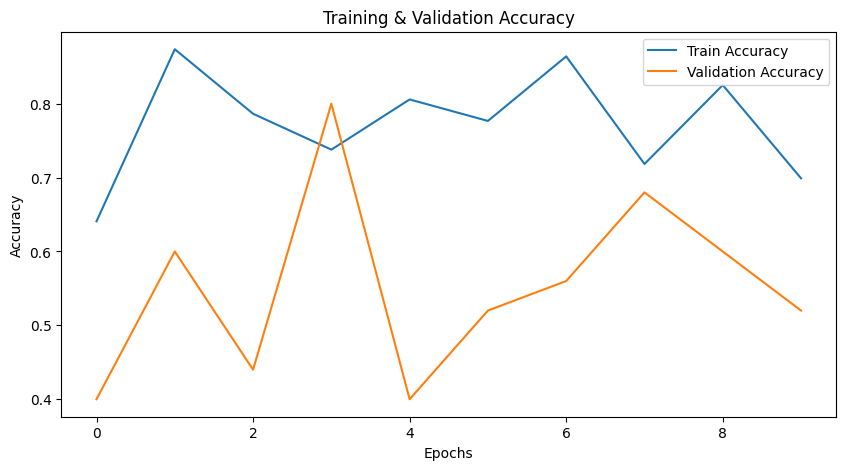

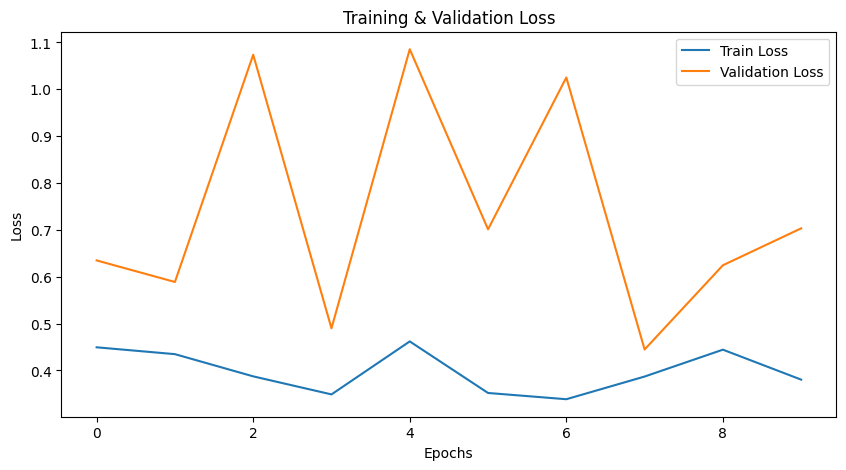

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy
plt.figure(figsize=(10,5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training & Validation Accuracy')
plt.show()

# Plot training & validation loss
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training & Validation Loss')
plt.show()


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train_dir = "/content/drive/My Drive/Major_Project"



In [ ]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='validation'
)


NameError: name 'image_size' is not defined

In [ ]:
print(f"Training samples: {train_generator.samples}")
print(f"Validation samples: {validation_generator.samples}")


Training samples: 103


NameError: name 'validation_generator' is not defined

In [ ]:
dataset_path = "/content/drive/MyDrive/Major_Project"


In [ ]:
import os

if os.path.exists(dataset_path):
    print("✅ Major_Project folder found!")
    print("Contents:", os.listdir(dataset_path))
else:
    print("❌ Folder NOT found! Check the path.")


✅ Major_Project folder found!
Contents: ['Negative', 'Positive', 'models']


In [ ]:
test_img = "/content/drive/MyDrive/Major_Project/Negative/1646599778299.jpg"


In [ ]:
if os.path.exists(test_img):
    print("✅ Image found!")
else:
    print("❌ Image NOT found! Check file name and extension.")


✅ Image found!


In [ ]:
from glob import glob

negative_images = glob("/content/drive/MyDrive/Major_Project/Negative/*.jpg")

if negative_images:
    test_img = negative_images[0]  # Pick first available image
    print(f"✅ Found an image: {test_img}")
else:
    print("❌ No images found in Negative folder!")


✅ Found an image: /content/drive/MyDrive/Major_Project/Negative/1646601843851.jpg


In [ ]:
from tensorflow.keras.preprocessing import image
import numpy as np

def preprocess_image(img_path):
    """Load and preprocess the image for model prediction."""
    try:
        img = image.load_img(img_path, target_size=(150, 150))  # Resize image
        img = image.img_to_array(img)  # Convert to NumPy array
        img = np.expand_dims(img, axis=0)  # Expand dimensions for batch
        img = img / 255.0  # Normalize pixel values
        return img
    except Exception as e:
        print(f"❌ Error loading image: {e}")
        return None


In [ ]:
import tensorflow as tf

model = tf.keras.models.load_model("/content/drive/MyDrive/hormonal_change_detection_model.h5", compile=False)


In [ ]:
model.compile(optimizer="adam",
              loss="binary_crossentropy",
              metrics=["accuracy"])


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import load_model

# Load model (update path if saved elsewhere)
model_path = "/content/drive/MyDrive/hormonal_change_detection_model.h5"
model = load_model(model_path)

def predict_image(img_path):
    img = preprocess_image(img_path)
    if img is None:
        print("❌ Image preprocessing failed!")
        return

    prediction = model.predict(img)[0][0]  # Get prediction value
    label = "Negative (Hormonal Change Detected)" if prediction > 0.5 else "Positive (No Hormonal Change)"

    print(f"Prediction: {label}")

In [ ]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 222, 222, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 109, 109, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 52, 52, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │      11,075,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,169,987 (42.61 MB)

 Trainable params: 11,169,537 (42.61 MB)

 Non-trainable params: 448 (1.75 KB)

 Optimizer params: 2 (12.00 B)

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing import image
import os

def preprocess_image(img_path):
    if not os.path.exists(img_path):
        raise FileNotFoundError(f"❌ Image not found: {img_path}")

    img = image.load_img(img_path, target_size=(224, 224))  # Match model input size
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    img /= 255.0  # Normalize pixel values
    return img

test_img_path = "/content/drive/MyDrive/Major_Project/Negative/1646599778299.jpg"

# Check if the image exists before proceeding
if os.path.exists(test_img_path):
    print("✅ Image found! Proceeding with prediction...")
else:
    raise FileNotFoundError(f"❌ Image not found: {test_img_path}")


✅ Image found! Proceeding with prediction...


In [ ]:
print(f"Raw Prediction Value: {prediction[0][0]}")


NameError: name 'prediction' is not defined

In [ ]:
threshold = 0.5  # Adjust if needed

label = "Negative (Hormonal Change Detected)" if prediction[0][0] < threshold else "Positive (No Hormonal Change)"

print(f"Prediction Score: {prediction[0][0]}")
print(f"Predicted Label (After Threshold Adjustment): {label}")


NameError: name 'prediction' is not defined

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing import image

def preprocess_image(img_path):
    """Load, resize, and preprocess the image to match the model's input."""
    img = image.load_img(img_path, target_size=(224, 224))  # Adjust size if needed
    img_array = image.img_to_array(img)  # Convert to NumPy array
    img_array = img_array / 255.0  # Normalize pixel values
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    return img_array

Processed Image Shape: (1, 224, 224, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step


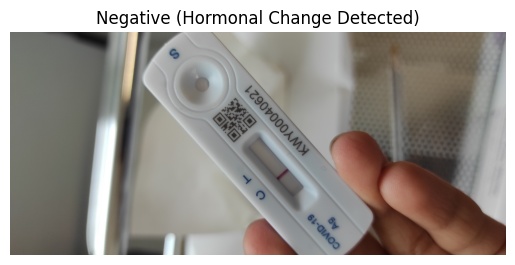

Prediction Score: 0.47878968715667725
Predicted Label: Negative (Hormonal Change Detected)


In [ ]:
# Preprocess the image
img_array = preprocess_image(test_img_path)

# Check shape before passing to the model
print("Processed Image Shape:", img_array.shape)  # Should be (1, 224, 224, 3)

# Predict
prediction = model.predict(img_array)

# Corrected label logic
label = "Negative (Hormonal Change Detected)" if prediction[0][0] < 0.5 else "Positive (No Hormonal Change)"

# Display the image with the result
import matplotlib.pyplot as plt
plt.imshow(image.load_img(test_img_path))
plt.axis("off")
plt.title(label)
plt.show()

print(f"Prediction Score: {prediction[0][0]}")
print(f"Predicted Label: {label}")


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
import matplotlib.pyplot as plt
import os
import cv2
from sklearn.model_selection import train_test_split
from google.colab import drive
import datetime
import pandas as pd
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Mount Google Drive
drive.mount('/content/drive')

# Configuration parameters
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 20
LEARNING_RATE = 0.0001
MODEL_NAME = "pregnancy_test_model"

# Paths - Google Drive dataset location
BASE_PATH = '/content/drive/MyDrive/Major_Project'  # ✅ Fixed path
POSITIVE_DIR = os.path.join(BASE_PATH, 'Positive')
NEGATIVE_DIR = os.path.join(BASE_PATH, 'Negative')
MODEL_SAVE_PATH = os.path.join(BASE_PATH, 'models')

# Ensure directories exist
if not os.path.exists(POSITIVE_DIR) or not os.path.exists(NEGATIVE_DIR):
    raise FileNotFoundError("Dataset folders not found. Check your Google Drive structure!")

print(f"✅ Dataset loaded from: {BASE_PATH}")

# Function to load and preprocess images
def load_images_from_folder(folder, label, max_samples=None):
    images, labels = [], []
    count = 0
    for img_name in os.listdir(folder):
        if img_name.endswith(('.jpg', '.jpeg', '.png')):
            img_path = os.path.join(folder, img_name)
            try:
                img = cv2.imread(img_path)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
                img = cv2.resize(img, IMG_SIZE)
                img = img / 255.0  # Normalize to [0, 1]
                images.append(img)
                labels.append(label)
                count += 1
                if max_samples and count >= max_samples:  # Stop if max_samples reached
                    break
            except Exception as e:
                print(f"Error processing {img_path}: {e}")

    return np.array(images), np.array(labels)

# Load POSITIVE samples separately
X_positive, y_positive = load_images_from_folder(POSITIVE_DIR, label=1, max_samples=260)

# Load NEGATIVE samples separately
X_negative, y_negative = load_images_from_folder(NEGATIVE_DIR, label=0, max_samples=33)

# Splitting dataset manually
X_train_pos, X_temp_pos, y_train_pos, y_temp_pos = train_test_split(X_positive, y_positive, test_size=0.077, random_state=42)  # 20 samples for validation+test
X_train_neg, X_temp_neg, y_train_neg, y_temp_neg = train_test_split(X_negative, y_negative, test_size=0.393, random_state=42)  # 13 samples for validation+test

# Split validation and test sets
X_val_pos, X_test_pos, y_val_pos, y_test_pos = train_test_split(X_temp_pos, y_temp_pos, test_size=0.5, random_state=42)  # 10 validation, 10 test
X_val_neg, X_test_neg, y_val_neg, y_test_neg = train_test_split(X_temp_neg, y_temp_neg, test_size=0.5, random_state=42)  # 2 validation, 3 test

# Combine positive and negative samples for training, validation, and testing
X_train = np.concatenate([X_train_pos, X_train_neg], axis=0)
y_train = np.concatenate([y_train_pos, y_train_neg], axis=0)

X_val = np.concatenate([X_val_pos, X_val_neg], axis=0)
y_val = np.concatenate([y_val_pos, y_val_neg], axis=0)

X_test = np.concatenate([X_test_pos, X_test_neg], axis=0)
y_test = np.concatenate([y_test_pos, y_test_neg], axis=0)

# Shuffle datasets
train_indices = np.arange(len(X_train))
np.random.shuffle(train_indices)
X_train, y_train = X_train[train_indices], y_train[train_indices]

val_indices = np.arange(len(X_val))
np.random.shuffle(val_indices)
X_val, y_val = X_val[val_indices], y_val[val_indices]

test_indices = np.arange(len(X_test))
np.random.shuffle(test_indices)
X_test, y_test = X_test[test_indices], y_test[test_indices]

# Print dataset distribution
print(f"✅ Training samples: {len(X_train)}")
print(f"✅ Validation samples: {len(X_val)}")
print(f"✅ Test samples: {len(X_test)}")
print(f"📂 Positive samples in training: {len(X_train_pos)}")
print(f"📂 Negative samples in training: {len(X_train_neg)}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Dataset loaded from: /content/drive/MyDrive/Major_Project
✅ Training samples: 110
✅ Validation samples: 9
✅ Test samples: 9
📂 Positive samples in training: 95
📂 Negative samples in training: 15


In [ ]:
# Data augmentation for training
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

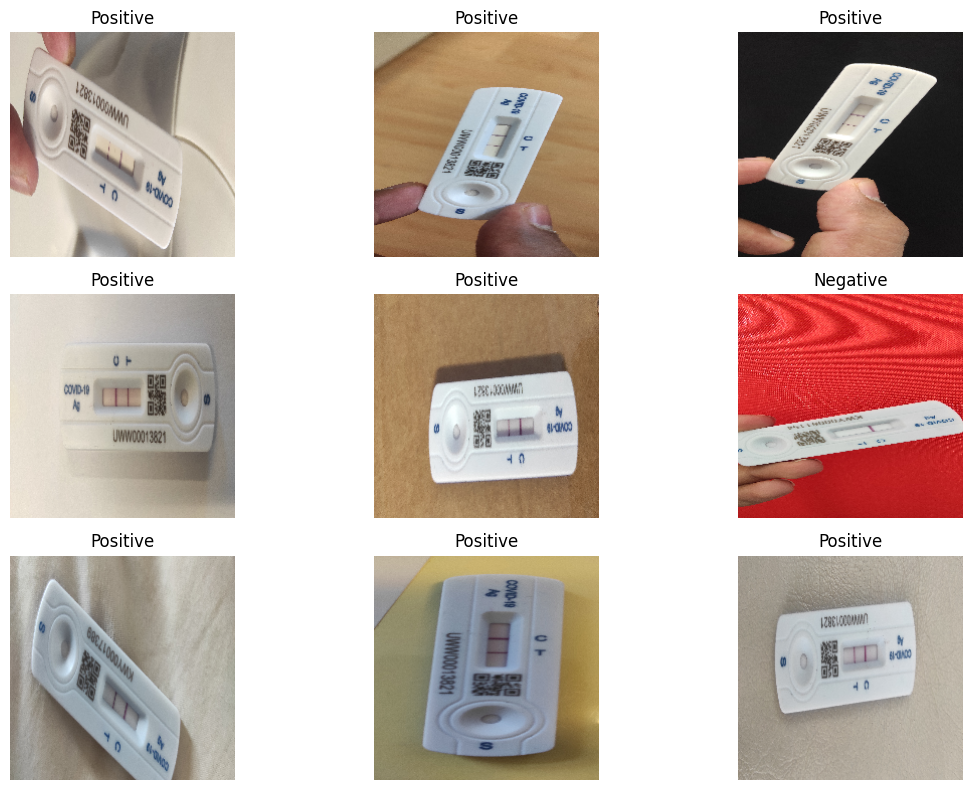

In [ ]:
# Visualize some training examples
plt.figure(figsize=(12, 8))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(X_train[i])
    plt.title("Positive" if y_train[i] == 1 else "Negative")
    plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
# Define the model using transfer learning with MobileNetV2
def create_model(input_shape=(224, 224, 3)):
    """
    Creates and returns a model using MobileNetV2 as the base model
    with custom top layers for binary classification
    """
    # Base model - MobileNetV2 with weights pre-trained on ImageNet
    base_model = MobileNetV2(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape
    )

    # Freeze the base model layers
    base_model.trainable = False

    # Create a new model on top
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dropout(0.2),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(1, activation='sigmoid')  # Binary classification
    ])

    return model

# Create the model
model = create_model()
model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
 #Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

 #Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

# Callbacks
callbacks_list = [
    callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    ),
    callbacks.ModelCheckpoint(
        filepath=os.path.join(MODEL_SAVE_PATH, MODEL_NAME + "_{epoch:02d}_{val_accuracy:.3f}.h5"),
        monitor='val_accuracy',
        save_best_only=True,
        mode='max'
    ),
    callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-6
    ),
    callbacks.TensorBoard(
        log_dir=os.path.join(MODEL_SAVE_PATH, 'logs', datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    )
]

# Train the model
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=BATCH_SIZE),
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    callbacks=callbacks_list
)

# Train the model
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=BATCH_SIZE),
    validation_data=(X_val, y_val),
    epochs=5,
    callbacks=callbacks_list
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1408 - loss: 1.4271 - precision_1: 0.6349 - recall_1: 0.0847

4/4 ━━━━━━━━━━━━━━━━━━━━ 44s 4s/step - accuracy: 0.1599 - loss: 1.3829 - precision_1: 0.6658 - recall_1: 0.0993 - val_accuracy: 0.4444 - val_loss: 0.7006 - val_precision_1: 0.4000 - val_recall_1: 0.5000 - learning_rate: 1.0000e-04
Epoch 2/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.5252 - loss: 0.7207 - precision_1: 0.8515 - recall_1: 0.5569 - val_accuracy: 0.4444 - val_loss: 0.8721 - val_precision_1: 0.4444 - val_recall_1: 1.0000 - learning_rate: 1.0000e-04
Epoch 3/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.7499 - loss: 0.5517 - precision_1: 0.8546 - recall_1: 0.8597 - val_accuracy: 0.4444 - val_loss: 1.1253 - val_precision_1: 0.4444 - val_recall_1: 1.0000 - learning_rate: 1.0000e-04
Epoch 4/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - accuracy: 0.8806 - loss: 0.4505 - precision_1: 0.8859 - recall_1: 0.9928 - val_accuracy: 0.4444 - val_loss: 1.3315 - val_precision_1: 0.4444 - val_recall_1: 1.0000 - learning_rate: 1.0000e-04
Epoch 5/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step

4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.4833 - loss: 0.8088 - precision_1: 0.9199 - recall_1: 0.4611 - val_accuracy: 0.6667 - val_loss: 0.7057 - val_precision_1: 0.5714 - val_recall_1: 1.0000 - learning_rate: 5.0000e-05
Epoch 2/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - accuracy: 0.4619 - loss: 0.7340 - precision_1: 0.7805 - recall_1: 0.5272 - val_accuracy: 0.5556 - val_loss: 0.7418 - val_precision_1: 0.5000 - val_recall_1: 1.0000 - learning_rate: 5.0000e-05
Epoch 3/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.6775 - loss: 0.6283 - precision_1: 0.8567 - recall_1: 0.7471 - val_accuracy: 0.5556 - val_loss: 0.8114 - val_precision_1: 0.5000 - val_recall_1: 1.0000 - learning_rate: 5.0000e-05
Epoch 4/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - accuracy: 0.8356 - loss: 0.5053 - precision_1: 0.8771 - recall_1: 0.9440 - val_accuracy: 0.4444 - val_loss: 0.9007 - val_precision_1: 0.4444 - val_recall_1: 1.0000 - learning_rate: 5.0000e-05
Epoch 5/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - ac

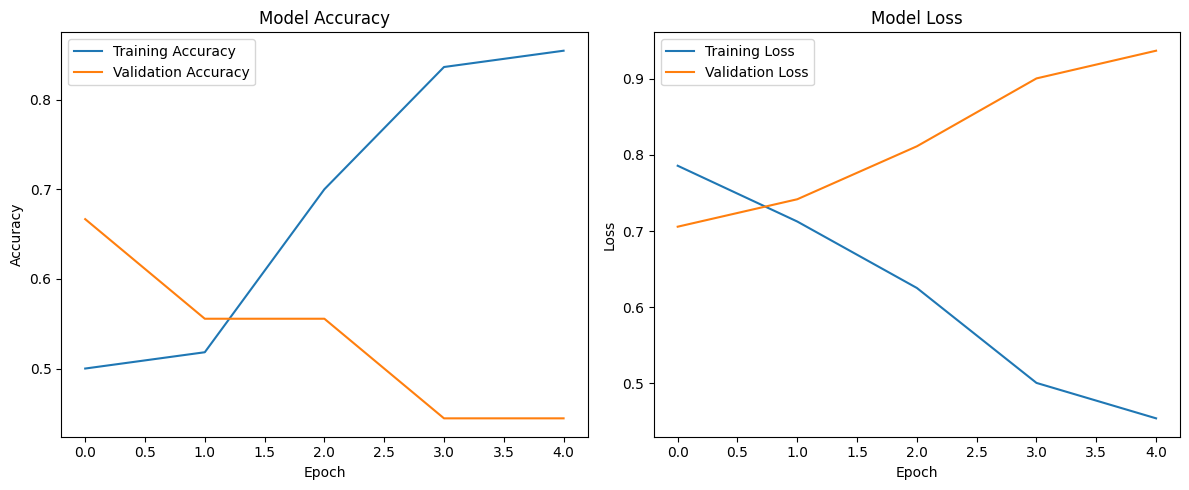

In [ ]:
# Plot training history
def plot_history(history):
    """
    Plots the training and validation accuracy and loss
    """
    plt.figure(figsize=(12, 5))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_history(history)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step - accuracy: 0.2222 - loss: 0.8378 - precision_1: 0.2857 - recall_1: 0.5000
Test Accuracy: 0.2222
Test Precision: 0.2857
Test Recall: 0.5000
Test F1 Score: 0.3636
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


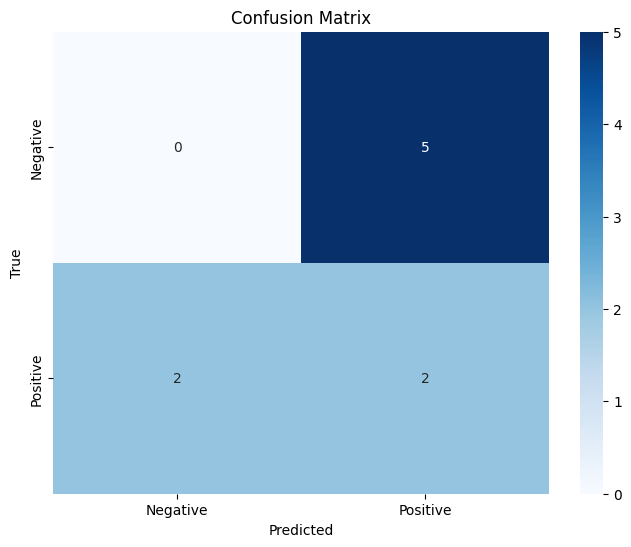

Classification Report:
              precision    recall  f1-score   support

    Negative       0.00      0.00      0.00         5
    Positive       0.29      0.50      0.36         4

    accuracy                           0.22         9
   macro avg       0.14      0.25      0.18         9
weighted avg       0.13      0.22      0.16         9



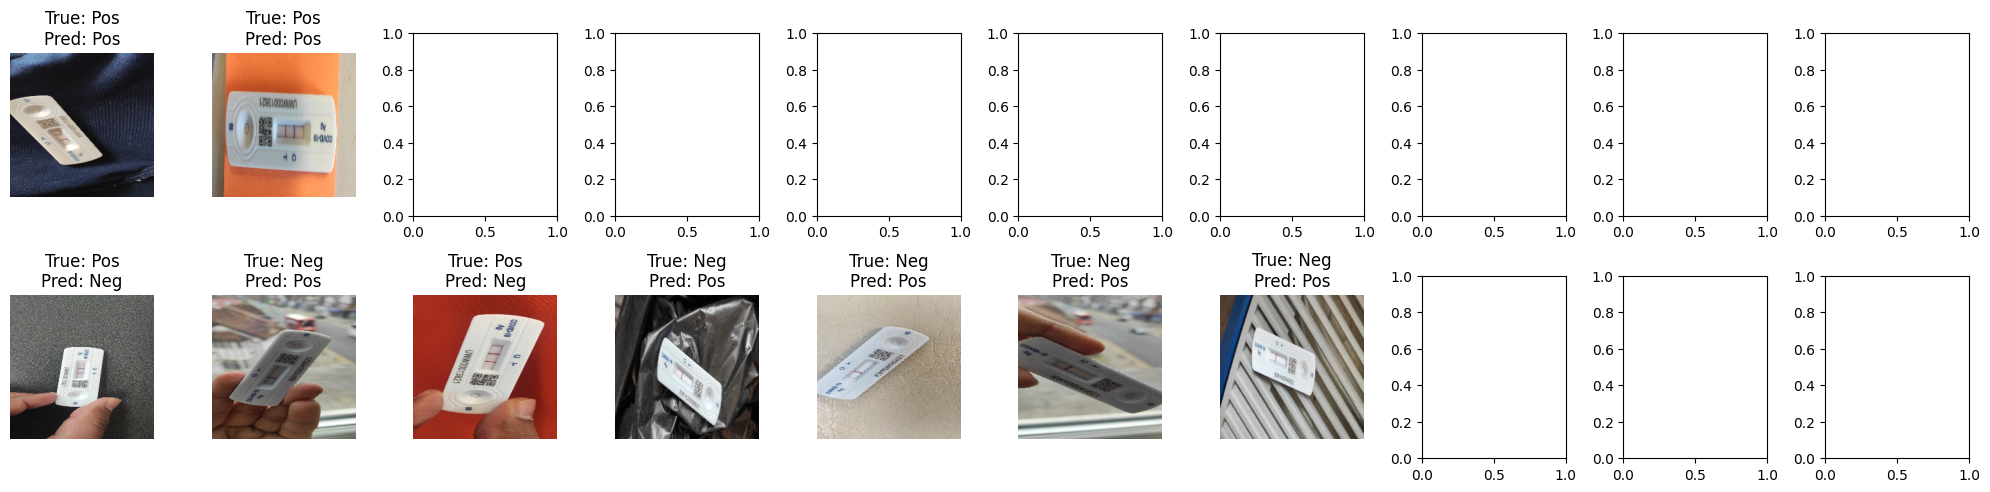

In [ ]:
# Evaluate on test set
test_loss, test_acc, test_precision, test_recall = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")

# Calculate F1 Score
test_f1 = 2 * (test_precision * test_recall) / (test_precision + test_recall)
print(f"Test F1 Score: {test_f1:.4f}")

# Make predictions on test set
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

# Confusion matrix
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Display classification report
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Negative', 'Positive']))

# Visualize some predictions
def plot_predictions(X, y_true, y_pred, n=10):
    """
    Visualizes the model's predictions on sample images
    """
    fig, axes = plt.subplots(2, n, figsize=(20, 5))

    # Find some correctly and incorrectly classified examples
    correct = np.where(y_true == y_pred)[0]
    incorrect = np.where(y_true != y_pred)[0]

    # Plot some correct predictions
    for i in range(min(n, len(correct))):
        idx = correct[i]
        axes[0, i].imshow(X[idx])
        axes[0, i].set_title(f"True: {'Pos' if y_true[idx] == 1 else 'Neg'}\nPred: {'Pos' if y_pred[idx] == 1 else 'Neg'}")
        axes[0, i].axis('off')

    # Plot some incorrect predictions
    for i in range(min(n, len(incorrect))):
        idx = incorrect[i]
        axes[1, i].imshow(X[idx])
        axes[1, i].set_title(f"True: {'Pos' if y_true[idx] == 1 else 'Neg'}\nPred: {'Pos' if y_pred[idx] == 1 else 'Neg'}")
        axes[1, i].axis('off')

    plt.tight_layout()
    plt.show()

plot_predictions(X_test, y_test, y_pred)

In [ ]:
# Create a function to test on new images
def test_on_new_image(model, image_path):
    """
    Tests the model on a new image and returns the prediction
    """
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, IMG_SIZE)

    img = img / 255.0
    img = np.expand_dims(img, axis=0)

    prediction = model.predict(img)[0][0]
    result = "Positive" if prediction > 0.7 else "Negative"
    confidence = prediction if prediction > 0.5 else 1 - prediction

    return result, confidence

In [ ]:
!ls "/content/drive/MyDrive/Major_Project/"


models	Negative  Positive


In [ ]:
image_path = "/content/drive/MyDrive/Major_Project/Positive/1649330009917.jpg"


In [ ]:
import tensorflow as tf
import cv2
import numpy as np
import os

# Define paths
model_path = "/content/drive/MyDrive/hormonal_change_detection_model.h5"
image_path = "/content/drive/MyDrive/Major_Project/Positive/1649330009917.jpg"  # ✅ Updated image path

# Check if model file exists
if not os.path.exists(model_path):
    raise FileNotFoundError(f"Model file not found at: {model_path}")

# Load the model
model = tf.keras.models.load_model(model_path)

# Check if image file exists
if not os.path.exists(image_path):
    print("🚨 Image file not found! Listing available files in the 'Positive' folder:")
    !ls "/content/drive/MyDrive/Major_Project/Positive/"
    raise FileNotFoundError(f"Image file not found at: {image_path}")

# Function to test on a new image
def test_on_new_image(model, image_path):
    """
    Tests the model on a new image and returns the prediction.
    """
    IMG_SIZE = (224, 224)  # Image size expected by model

    # Read and preprocess the image
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, IMG_SIZE)
    img = img / 255.0  # Normalize pixel values
    img = np.expand_dims(img, axis=0)  # Add batch dimension

    # Predict
    prediction = model.predict(img)[0][0]

    # Determine result
    result = "Positive" if prediction > 0.7 else "Negative"
    confidence = prediction if prediction > 0.5 else 1 - prediction

    print(f"Prediction: {result} (Confidence: {confidence:.2f})")
    return result, confidence

# Run the function
test_on_new_image(model, image_path)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
Prediction: Negative (Confidence: 0.52)


('Negative', 0.5193547606468201)

In [ ]:
import os
print(os.path.exists("/content/drive/MyDrive/hormonal_change_detection_model.h5"))


True


In [ ]:
import tensorflow as tf
import cv2
import numpy as np
import os

# Define paths
model_path = "/content/drive/MyDrive/hormonal_change_detection_model.h5"
image_path = "/content/drive/MyDrive/Major_Project/Positive/1649330009917.jpg"

# Check if model file exists
if not os.path.exists(model_path):
    raise FileNotFoundError(f"Model file not found at: {model_path}")

# Load the model
model = tf.keras.models.load_model(model_path)

# Check if image file exists
if not os.path.exists(image_path):
    raise FileNotFoundError(f"Image file not found at: {image_path}")

# Function to test on a new image
def test_on_new_image(model, image_path):
    """
    Tests the model on a new image and returns the prediction.
    """
    IMG_SIZE = (224, 224)  # Image size expected by model

    # Read and preprocess the image
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, IMG_SIZE)
    img = img / 255.0  # Normalize pixel values
    img = np.expand_dims(img, axis=0)  # Add batch dimension

    # Predict
    prediction = model.predict(img)[0][0]

    # Determine result
    result = "Positive" if prediction > 0.7 else "Negative"
    confidence = prediction if prediction > 0.5 else 1 - prediction

    print(f"Prediction: {result} (Confidence: {confidence:.2f})")
    return result, confidence

# Run the function
test_on_new_image(model, image_path)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
Prediction: Negative (Confidence: 0.52)


('Negative', 0.5193547606468201)

In [ ]:
!pip install streamlit
!pip install pyngrok


In [ ]:
!nohup streamlit run app.py --server.port 8501 > streamlit.log 2>&1 &


In [ ]:
!ngrok authtoken 2u8tlK2Qtf5qdJ0XpyBETZVl2PT_3xurRXXRQqaY7SBaQFnxP


Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [ ]:
confidence = float(prediction[0][0])


In [ ]:
st.write(f"Confidence Score: {confidence}")


NameError: name 'st' is not defined

In [ ]:
!pip install pyngrok



In [ ]:
!pip install --upgrade pyngrok


In [ ]:
pip install --upgrade streamlit


In [ ]:
%%writefile app.py
import streamlit as st
import tensorflow as tf
import numpy as np
import pandas as pd
import datetime
from PIL import Image

# Constants
IMG_SIZE = (224, 224)

# Initialize session state
if "history" not in st.session_state:
    st.session_state.history = []

# Load the trained model
model_path = "/content/drive/MyDrive/hormonal_change_detection_model.h5"
model = tf.keras.models.load_model(model_path)

# Function to preprocess image
def preprocess_image(image):
    image = image.resize(IMG_SIZE)
    image = np.array(image) / 255.0
    image = np.expand_dims(image, axis=0)
    return image

# Streamlit UI
st.set_page_config(page_title="Pregnancy Test Analyzer", layout="wide")
st.title("\U0001F3E5 Pregnancy Test Analysis System")

uploaded_file = st.file_uploader("\U0001F4E4 Upload Pregnancy Test Image", type=["jpg", "png", "jpeg"])

if uploaded_file:
    image = Image.open(uploaded_file)
    st.image(image, caption="Test Image", use_column_width=True)

    processed_img = preprocess_image(image)
    prediction = model.predict(processed_img)
    confidence = float(prediction[0][0])  # Extract confidence score
    date = datetime.datetime.now().strftime("%Y-%m-%d %H:%M")

    # Analysis results
    st.subheader("\U0001F50D Analysis Results")
    st.markdown(f"**Confidence Score:** `{confidence:.2f}`")

    if confidence >= 0.7:
        status = "Positive"
        color = "green"
        result_type = "True Positive"
        recommendations = [
            "Schedule an appointment with your healthcare provider.",
            "Begin taking prenatal vitamins.",
            "Avoid alcohol and smoking.",
            "Consider lifestyle modifications."
        ]
    elif confidence >= 0.5:
        status = "Positive"
        color = "orange"
        result_type = "False Positive"
        recommendations = [
            "Retest with another test kit for confirmation.",
            "Consult a healthcare provider for further evaluation.",
            "Consider testing with a blood test for more accuracy."
        ]
    elif confidence >= 0.3:
        status = "Negative"
        color = "red"
        result_type = "False Negative"
        recommendations = [
            "If period is missed, retest in a few days.",
            "Test with a different brand for accuracy.",
            "Consult a doctor if symptoms persist."
        ]
    else:
        status = "Negative"
        color = "blue"
        result_type = "True Negative"
        recommendations = [
            "No pregnancy detected.",
            "Track your menstrual cycle.",
            "Maintain a healthy lifestyle.",
            "If concerned, consult a doctor."
        ]

    st.markdown(f"### Test Result: :{color}[{result_type}]")

    # Save to history
    st.session_state.history.append({
        "date": date,
        "result": result_type,
        "confidence_score": confidence
    })

    # Display recommendations
    st.markdown("### \U0001F4CB Recommended Actions")
    for rec in recommendations:
        st.write(f"• {rec}")

    # Additional information based on result
    st.markdown("### ℹ️ Important Information")
    if status == "Positive":
        st.info("""
        - A positive result indicates pregnancy hormone (hCG) was detected.
        - False positives can occur due to certain medications or medical conditions.
        - Confirm result with a healthcare provider.
        - Different tests have varying sensitivity levels.
        """)
    else:
        st.info("""
        - A negative result indicates pregnancy hormone (hCG) was not detected.
        - If your period is late, consider retesting in a few days.
        - False negatives are possible if testing too early.
        - Follow test instructions carefully for accurate results.
        """)

# Export functionality
st.markdown("---")
if st.session_state.history:
    if st.button("\U0001F4E5 Export Analysis History"):
        df = pd.DataFrame(st.session_state.history)
        st.download_button(
            label="Download Analysis Data",
            data=df.to_csv(index=False),
            file_name=f"pregnancy_test_analysis_{datetime.datetime.now().strftime('%Y%m%d')}.csv",
            mime="text/csv"
        )


Overwriting app.py


In [ ]:
from pyngrok import ngrok
import subprocess

# Kill any previous tunnels
!pkill -9 streamlit
!pkill -9 ngrok

# Start Streamlit app in the background
subprocess.Popen(["streamlit", "run", "app.py", "--server.port", "8501"])

# Create a tunnel to expose port 8501
public_url = ngrok.connect(8501).public_url
print(f"Streamlit App URL: {public_url}")


Streamlit App URL: https://648b-35-201-192-199.ngrok-free.app
